In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [50]:
df=pd.read_csv('DM2425_ABCDEats_DATASET.csv',delimiter=',')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31888 entries, 0 to 31887
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               31888 non-null  object 
 1   customer_region           31888 non-null  object 
 2   customer_age              31161 non-null  float64
 3   vendor_count              31888 non-null  int64  
 4   product_count             31888 non-null  int64  
 5   is_chain                  31888 non-null  int64  
 6   first_order               31782 non-null  float64
 7   last_order                31888 non-null  int64  
 8   last_promo                31888 non-null  object 
 9   payment_method            31888 non-null  object 
 10  CUI_American              31888 non-null  float64
 11  CUI_Asian                 31888 non-null  float64
 12  CUI_Beverages             31888 non-null  float64
 13  CUI_Cafe                  31888 non-null  float64
 14  CUI_Ch

# Drop Dublicates

We need to eliminate duplicates to prevent further issues, especially with the index setting

In [52]:
df.duplicated().sum()

np.int64(13)

In [53]:
df=df.drop_duplicates()
# Count the number of remaining duplicate rows in the DataFrame after dropping duplicates
df.duplicated().sum()

np.int64(0)

# Set costumer_id as the index

In [54]:
df.set_index('customer_id', inplace=True)

## Fixing variables

**customer_age**

Fill missing values with median

In [55]:
df['customer_age'].isna().sum()

np.int64(727)

In [56]:
df['customer_age'] = df['customer_age'].fillna(df['customer_age'].median())
df['customer_age'].isna().sum()

np.int64(0)

**costumer_region**

Replace the value of '-' with 'Unknown' to enhance the interpretation of the feature

In [57]:
df.loc[:, 'customer_region'] = df['customer_region'].replace('8550', '-')

In [58]:
df.loc[:, 'customer_region'] = df['customer_region'].replace('-', np.nan)

In [59]:
mode_value = df['customer_region'].mode()[0]
df['customer_region'] = df['customer_region'].fillna(mode_value)

In [60]:
df['customer_region'].value_counts()

customer_region
8670    10216
4660     9550
2360     8829
2440     1483
4140      857
8370      495
2490      445
Name: count, dtype: int64

**product_count**

There is an extreme product count value with '92ced2dcb9' index, so we will transform it into a high value

In [61]:
df.loc['92ced2dcb9','product_count']=100

**first_order**

Fill missing values with median

In [62]:
df['first_order'] = df['first_order'].fillna(df['first_order'].median())

**last_promo**

Replace the value of '-' with 'no_promotion_used' to enhance the interpretation of the feature

In [63]:
df['last_promo'] = df['last_promo'].replace('-', 'no_promotion_used')

**HR_0**

Drop the column labeled "HR_0" because it contains only zeros.

In [64]:
df.drop(columns=['HR_0'], inplace=True)

#Fixing inconsistencies

Eliminate rows where there are inconsistencies

In [65]:
df['sum_HR']=df['HR_1']+df['HR_2']+df['HR_3']+df['HR_4']+df['HR_5']+df['HR_6']+df['HR_7']+df['HR_8']+df['HR_9']+df['HR_10']+df['HR_11']+df['HR_12']+df['HR_13']+df['HR_14']+df['HR_15']+df['HR_16']+df['HR_17']+df['HR_18']+df['HR_19']+df['HR_20']+df['HR_21']+df['HR_22']+df['HR_23']
df['sum_DOW']=df['DOW_0']+df['DOW_1']+df['DOW_2']+df['DOW_3']+df['DOW_4']+df['DOW_5']+df['DOW_6']
df['inc_0']=(df['sum_HR']!=df['sum_DOW'])
df['inc_2']=(df['product_count']==0)
df = df.loc[~(df['inc_0'] | df['inc_2'])]
df = df.drop(columns=['sum_HR', 'sum_DOW', 'inc_0', 'inc_2'])

# New variables

**Total_Spent**

In [66]:
cuisine = [col for col in df.columns if col.startswith('CUI_')]

In [67]:
df['Total_Spent']=df[cuisine].sum(axis=1)

Deal with extreme outliers

In [68]:
df = df.drop('92ced2dcb9', axis=0)
df.loc['249ba584d3','CUI_Asian']=500
df.loc['8d65421423','CUI_Japanese']=590
df['Total_Spent']=df[cuisine].sum(axis=1)

**Order_Count**

In [69]:
df['order_count']=df['DOW_0']+df['DOW_1']+df['DOW_2']+df['DOW_3']+df['DOW_4']+df['DOW_5']+df['DOW_6']

**Diversity_Cuisine**

In [70]:
df['Diversity_Cuisine'] = (df[cuisine] > 0).sum(axis=1)
df['Diversity_Cuisine'] = df['order_count']/df['Diversity_Cuisine']

**Costumer_time**

In [71]:
df['costumer_time']=df['last_order']-df['first_order']

**Intensity_of_Activity**

In [72]:
df['Intensity_of_Activity'] = df['costumer_time'] / df['order_count']

**Customer_Loyalty**

In [73]:
df['Customer_loyalty'] = df['vendor_count'] / df['order_count']

**Product_Intensity**

In [74]:
df['product_intensity'] = df['product_count'] / df['order_count']

**Day_Week_Spread**

In [75]:
days = [col for col in df.columns if col.startswith('DOW_')]

In [76]:
df['Day_Week_Spread'] = df.loc[:,days].var(axis=1)

**hour_spread**

In [77]:
hours=[col for col in df.columns if col.startswith('HR_')]

In [78]:
df['hour_spread'] = df.loc[:,hours].var(axis=1)

In [79]:
df.to_csv('df_Clean.csv')

# Normalize data

In [80]:
#Select numeric features
metric_features = df.select_dtypes(include=['number']).columns.tolist()

In [81]:
# Normalize numeric data with Min-Max scaler
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df[metric_features])
df[metric_features] = scaled_feat

In [82]:
#Select categorical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [83]:
def encode_by_proportion(df,column_name):
    category_proportions = df[column_name].value_counts(normalize=True)

    df[column_name] = df[column_name].map(category_proportions)
    
    return df

In [84]:
ohc_df = df.copy()
ohc_df=ohc_df[categorical_features]
for i in ohc_df.columns:
    ohc_df=encode_by_proportion(ohc_df,i)
df[categorical_features]=ohc_df

# Separate data by  demographic segmentation and behaviour-based segmentation

In [85]:
df_demo=df['customer_age']

In [86]:
df = df.drop('customer_age', axis=1)

In [87]:
df_demo.to_csv('df_demo.csv')

# PCA analisys

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30554 entries, 1b8f824d5e to fd40d3b0e0
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_region           30554 non-null  float64
 1   vendor_count              30554 non-null  float64
 2   product_count             30554 non-null  float64
 3   is_chain                  30554 non-null  float64
 4   first_order               30554 non-null  float64
 5   last_order                30554 non-null  float64
 6   last_promo                30554 non-null  float64
 7   payment_method            30554 non-null  float64
 8   CUI_American              30554 non-null  float64
 9   CUI_Asian                 30554 non-null  float64
 10  CUI_Beverages             30554 non-null  float64
 11  CUI_Cafe                  30554 non-null  float64
 12  CUI_Chicken Dishes        30554 non-null  float64
 13  CUI_Chinese               30554 non-null  float64
 1

In [89]:
metric_features = df.select_dtypes(include=['number']).columns.tolist()
metric_features.remove('last_promo')
metric_features.remove('payment_method')
metric_features.remove('customer_region')
X = df[metric_features]
pca = PCA().fit(X)

In [90]:
PCA_s=pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)
PCA_s.head(20)

,Eigenvalue,Difference,Proportion,Cumulative
1,0.158237,0.000000,0.425636,0.425636
2,0.085736,-0.072501,0.230617,0.656253
3,0.043986,-0.041749,0.118317,0.774570
4,0.020823,-0.023163,0.056011,0.830581
5,0.007863,-0.012960,0.021149,0.851731
6,0.004534,-0.003328,0.012197,0.863928
7,0.003645,-0.000890,0.009804,0.873731
8,0.003178,-0.000467,0.008549,0.882280
9,0.002890,-0.000288,0.007773,0.890053
10,0.002525,-0.000365,0.006791,0.896844


In [91]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=X.columns)
print(loadings)

                               PC1       PC2       PC3       PC4       PC5  \
vendor_count              0.103836  0.007052  0.033605 -0.317628 -0.066511   
product_count             0.095717  0.009165 -0.065709 -0.260967  0.046158   
is_chain                  0.067863  0.003502 -0.039806 -0.188997 -0.088874   
first_order              -0.446201  0.690839 -0.145256 -0.025415 -0.002715   
last_order                0.359143  0.719291  0.202717  0.024875 -0.003153   
CUI_American              0.029060  0.002159 -0.020634 -0.058329  0.025586   
CUI_Asian                 0.021611  0.005562  0.001702 -0.067763  0.152612   
CUI_Beverages             0.011955  0.000564  0.000314 -0.047124  0.046175   
CUI_Cafe                  0.007447  0.001285 -0.009381 -0.027572 -0.001228   
CUI_Chicken Dishes        0.006694 -0.000104 -0.002437 -0.020653 -0.013516   
CUI_Chinese               0.006541  0.000507 -0.004086 -0.021039  0.004750   
CUI_Desserts              0.003737  0.000718  0.002431 -0.017203

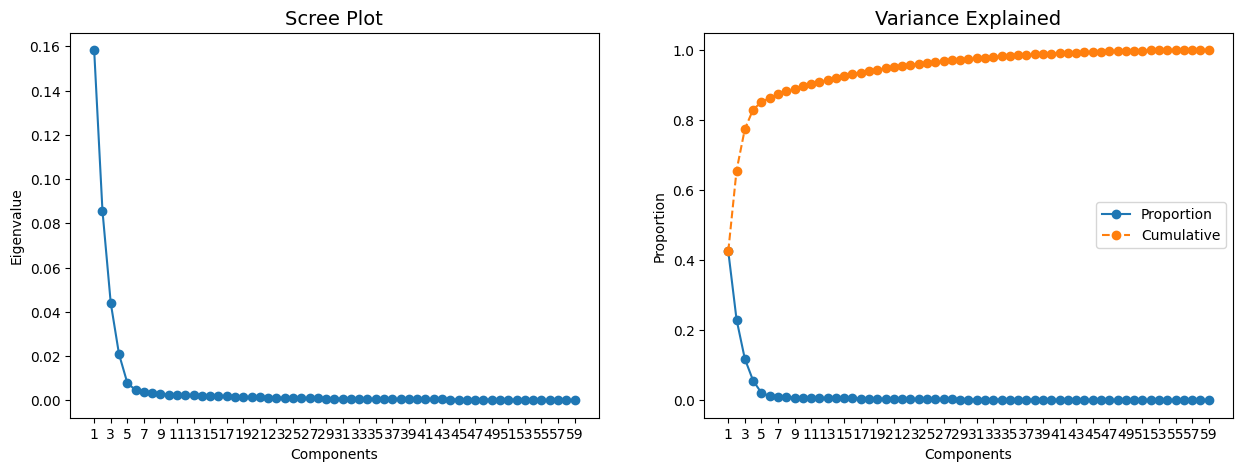

In [92]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

We decided to establish a threshold of 85% cumulative variance, so we will retain the first 5 components

In [93]:
#Retain the first 5 components
pca = PCA(n_components=5)
pca_feat = pca.fit_transform(df[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
#Create the dataframe "df_PCA" with the PC`s and the normalized categorical features
df_PCA = pd.DataFrame(pca_feat, index=df.index, columns=pca_feat_names)
#Normalize the PC features
metric_features1 = df_PCA.select_dtypes(include=['number']).columns.tolist()
scaled_feat = scaler.fit_transform(df_PCA[metric_features1])
df_PCA = scaled_feat
df_PCA = pd.DataFrame(df_PCA, index=df.index, columns=metric_features1)

# Outlier removing using DBSCAN

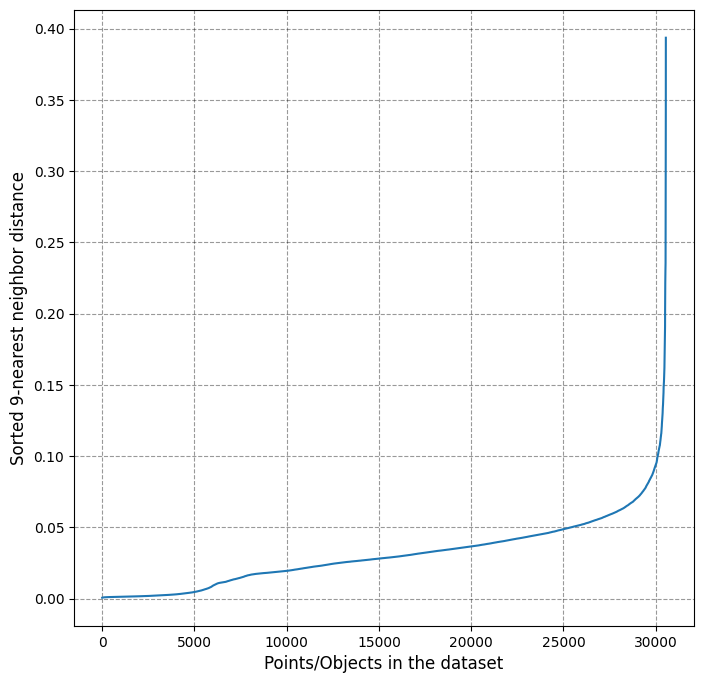

In [94]:
from sklearn.neighbors import NearestNeighbors
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * df_PCA.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=df_PCA, k=k)

In [143]:
from sklearn.cluster import DBSCAN
epsilon = 0.08  
min_samples = 10  
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(df_PCA)

In [144]:
df_PCA['Cluster'] = clusters

In [145]:
df_PCA['Cluster'].value_counts()

Cluster
 0     28127
-1      1197
 4       280
 16      113
 19       90
 3        85
 31       80
 14       44
 21       43
 7        34
 18       33
 10       32
 24       31
 23       28
 15       28
 2        27
 13       23
 32       23
 12       22
 9        22
 5        19
 26       19
 6        18
 30       17
 11       16
 28       14
 17       13
 25       13
 27       11
 1        11
 20       11
 8        10
 22       10
 29       10
Name: count, dtype: int64

In [146]:
df_PCA = df_PCA[df_PCA['Cluster'] != -1].reset_index(drop=True)

In [147]:
df_PCA=df_PCA.drop('Cluster',axis=1)
df_PCA.to_csv('df_behaviour.csv')